In [150]:
import os
import folium
import numpy as np
import pandas as pd
import pyproj as pj
import math
from folium.plugins import HeatMap
from collections import Counter
import matplotlib
import matplotlib.pyplot as plt
from scipy.ndimage.interpolation import shift
import scipy.stats as stats
from scipy.stats import norm
import matplotlib.mlab as mlab
import pylab as pl
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
# gps.csv contains five features: user_id, record_time, latitude, longitude, accu
gps_df = pd.read_csv("gps.csv")

In [3]:
# battery.csv contains four features: user_id, record_time, level, plugged
battery_df = pd.read_csv("battery.csv")

In [4]:
# app_usage.csv contains two features: user_id, record_time, app_name, fg_time_ms, interval_ms
app_usage_df = pd.read_csv("app_usage.csv")

In [83]:
# latitude and longitude of saskatoon center
lat_center_saskatoon = (52.058367 + 52.214608) / 2
lon_center_saskatoon = (-106.7649138128 - 106.52225318) / 2

In [5]:
# calculate number of total possible battery records per particiants
battery_df.record_time = battery_df.record_time.astype('datetime64')
time_interval = battery_df.record_time.max() - battery_df.record_time.min()
num_total_possible_records = np.ceil(time_interval.total_seconds() / 300)

In [6]:
# calculate the number of all battery records per user.
battery_counts_df = battery_df.groupby(['user_id']).size().reset_index(name='counts')

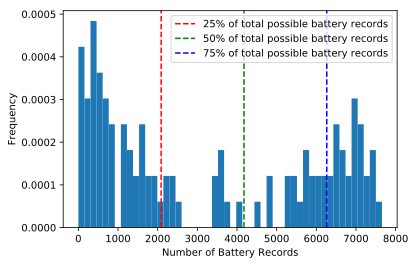

In [219]:
(mu, sigma) = norm.fit(battery_counts_df.counts)

# the histogram of the data
n, bins, patches = plt.hist(battery_counts_df.counts, 50, normed=1)

# add a 'best fit' line

plt.xlabel('Number of Battery Records')
plt.ylabel('Frequency')
#plt.title('Battery Level Distribution When not Charging')
#plt.savefig('./imgs/battery_dist_not_charging.pdf', bbox_inches='tight')
plt.axvline(x=0.25 * num_total_possible_records, color = 'r', linestyle='--')
plt.axvline(x=0.5 * num_total_possible_records, color = 'g', linestyle='--')
plt.axvline(x=0.75 * num_total_possible_records, color = 'b', linestyle='--')
plt.legend(['25% of total possible battery records', '50% of total possible battery records', '75% of total possible battery records'])
plt.savefig('./imgs/dist_num_of_battery_records_per_participants.pdf', bbox_inches='tight')

In [7]:
# filter battery dataframe in 50% threshold
fifty_user_df = battery_counts_df[battery_counts_df.counts >= num_total_possible_records * 0.5]

In [8]:
# convert the datatype of record_time from object to datatime64
gps_df.record_time = gps_df.record_time.astype('datetime64')

In [9]:
def join_battery_and_gps_per_user_id(battery_df, gps_df, user_id):
    temp_battery_df = battery_df[battery_df.user_id == user_id]
    temp_gps_df = gps_df[gps_df.user_id == user_id]
    
    if (temp_battery_df.empty or temp_gps_df.empty):
        return pd.DataFrame()
    
    temp_battery_df = temp_battery_df.groupby(['record_time']).mean().reset_index()
    temp_gps_df = temp_gps_df.groupby(['record_time']).mean().reset_index()
    
    temp_gps_df = temp_gps_df.drop(columns=['user_id'])
    
    temp_joint_df = pd.merge_asof(temp_battery_df, temp_gps_df, on='record_time', direction='nearest')
    
    return temp_joint_df

In [10]:
battery_gps_df = pd.DataFrame()

for user_id in fifty_user_df.user_id.values:
    temp = join_battery_and_gps_per_user_id(battery_df, gps_df, user_id)
    battery_gps_df = battery_gps_df.append(temp, ignore_index=True)

In [15]:
# remove all GPS traces outside the city limits of Greater Saskatoon and an accuracy of 100m or worse
battery_gps_df = battery_gps_df[(battery_gps_df.lat <= 52.214608) & (battery_gps_df.lat >= 52.058367) & (battery_gps_df.lon <= -106.52225318) & (battery_gps_df.lon >= -106.7649138128) & (battery_gps_df.accu <= 100)]

In [124]:
battery_gps_df.shape

(237763, 9)

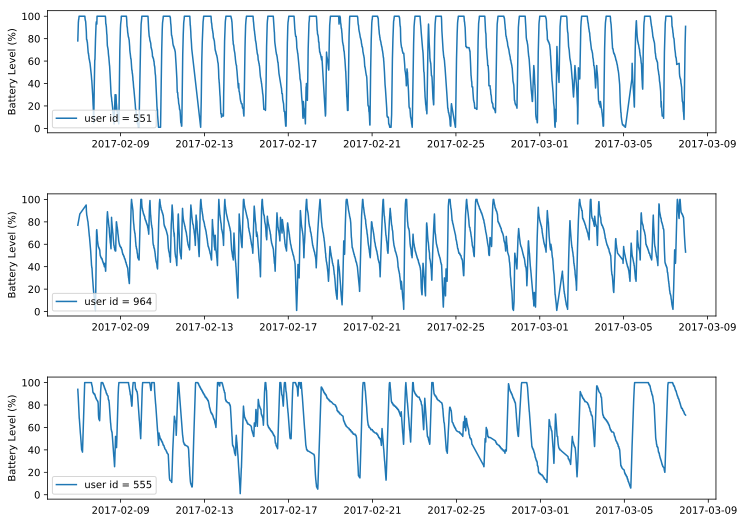

In [202]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12,9))
fig.subplots_adjust(hspace=0.5)

ax1.plot(battery_gps_df[battery_gps_df.user_id == 551].record_time, battery_gps_df[battery_gps_df.user_id == 551].level)
ax1.legend(["user id = 551"])
ax1.set_ylabel('Battery Level (%)')

ax2.plot(battery_gps_df[battery_gps_df.user_id == 964].record_time, battery_gps_df[battery_gps_df.user_id == 964].level)
ax2.legend(["user id = 964"])
ax2.set_ylabel('Battery Level (%)')

ax3.plot(battery_gps_df[battery_gps_df.user_id == 555].record_time, battery_gps_df[battery_gps_df.user_id == 555].level)
ax3.legend(["user id = 555"])
ax3.set_ylabel('Battery Level (%)')
#plt.setp(ax.get_xticklabels(), rotation=0, ha="center")
plt.savefig('./imgs/typical_time_plot.pdf', bbox_inches='tight')

In [140]:
level_counts = battery_gps_df.groupby(['level']).size().reset_index(name='counts')

In [181]:
not_full = battery_gps_df[battery_gps_df.level < 100]
not_full_not_charge = not_full[not_full.plugged == 0]
not_full_charge = not_full[not_full.plugged != 0]
charge = battery_gps_df[battery_gps_df.plugged != 0]
not_charge = battery_gps_df[battery_gps_df.plugged == 0]

In [182]:
f = plt.figure(figsize=(10,3))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)
x = np.linspace(0,4,1000)
ax.plot(x, np.sin(x))
ax2.plot(x, np.cos(x), 'r:')

/Users/wbb/anaconda3/envs/cmpt826/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
  import sys


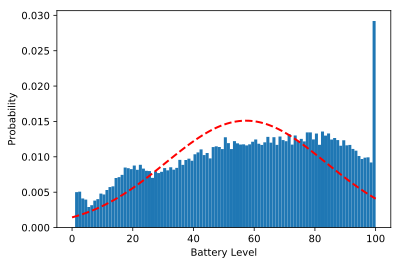

In [198]:
(mu, sigma) = norm.fit(not_charge.level)

# the histogram of the data
n, bins, patches = plt.hist(not_charge.level, 100, normed=1)

# add a 'best fit' line
y = mlab.normpdf(bins, mu, sigma)
l = plt.plot(bins, y, 'r--', linewidth=2)

plt.xlabel('Battery Level')
plt.ylabel('Probability')
#plt.title('Battery Level Distribution When not Charging')
plt.savefig('./imgs/battery_dist_not_charging.pdf', bbox_inches='tight')

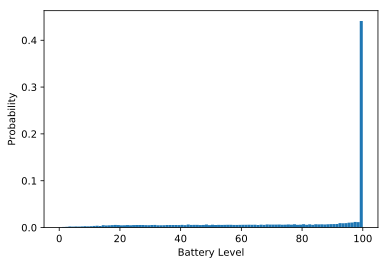

In [199]:
# the histogram of the data
n, bins, patches = plt.hist(charge.level, 100, normed=1)

plt.xlabel('Battery Level')
plt.ylabel('Probability')
#plt.title('Battery Level Distribution When Charging')
plt.savefig('./imgs/battery_dist_charging.pdf', bbox_inches='tight')

In [108]:
level_100_battery_gps_df = battery_gps_df

In [109]:
# transfer latitude and longitude coordinates to UTM coordinates
p1 = pj.Proj(init='epsg:32613')
x, y = p1(level_100_battery_gps_df.lon.values.tolist(), level_100_battery_gps_df.lat.values.tolist())
level_100_battery_gps_df.loc[:, 'x'] = x
level_100_battery_gps_df.loc[:, 'y'] = y

In [110]:
level_100_battery_gps_df = level_100_battery_gps_df.drop(columns=['accu', 'lat', 'lon'])

In [111]:
# calculate the start and end coordinates in UTM for the greater Saskatoon area
start_x, start_y = p1(-106.7649138128, 52.058367)
end_x, end_y = p1(-106.52225318, 52.214608)

In [112]:
# convert UTM coordinates into grid coordinates
def which_grid(x, y, start_x, start_y, step):
    which_grid_x = np.floor((x - start_x) / step)
    which_grid_y = np.floor((y - start_y) / step)
    
    # in case UTM coordinates in the boundary of the greater Saskatoon area
    # there are some -1 value appearing
    # set all -1 to 0
    which_grid_x[which_grid_x < 0] = 0
    which_grid_y[which_grid_y < 0] = 0
    
    return(which_grid_x, which_grid_y)

In [120]:
def operationalize(df, lat_center_saskatoon, lon_center_saskatoon, start_x, end_x, start_y, end_y, step, is_plugged = True):
  
    # remove all unplugged data
    if is_plugged:
        df = df[df.plugged != 0]
        df = df[df.level == 100]
        
    # convert UTM coordinates into grid coordinates
    
    df.loc[:, 'grid_x'], df.loc[:, 'grid_y'] = which_grid(df.x.values, df.y.values, start_x, start_y, step)
    df = df.drop(columns=['x', 'y'])
    
    #convert datatype from float64 to int
    df.grid_x = df.grid_x.astype('int')
    df.grid_y = df.grid_y.astype('int')
    
    # Convert grid coordinates back to lat and lon coordinates
    temp_x = (df.grid_x + 0.5) * step + start_x
    temp_y = (df.grid_y + 0.5) * step + start_y
    temp_x[temp_x > end_x] = end_x
    temp_y[temp_y > end_y] = end_y
    df.loc[:, 'center_lon'], df.loc[:, 'center_lat'] = p1(temp_x.tolist(), temp_y.tolist(), inverse=True)
    m = folium.Map([lat_center_saskatoon, lon_center_saskatoon], tiles='stamentoner', zoom_start=6)
    # render the heatmap
    HeatMap(df[['center_lat', 'center_lon']].values.tolist()).add_to(m)
    filename = "step_" + str(step) + "_100_level_charging_heatmap.html"
    m.save(os.path.join('.', filename))

In [121]:
operationalize(level_100_battery_gps_df, lat_center_saskatoon, lon_center_saskatoon, start_x, end_x, start_y, end_y, 100)

In [98]:
level_100_battery_gps_df.groupby('plugged').size()

plugged
0     3330
1    28061
2      943
dtype: int64